In [1]:
%matplotlib notebook
#Ziyan Zhu
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import socket
import getpass
import nntools as nt
from VOCdataset import VOCDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
print(torch.__version__)

1.1.0


In [4]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [5]:
labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
color = {}
for i in range(len(labels)):    
    color[labels[i]] = np.random.random(3)
    
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = image 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    if type(boxes['boxes']) == 'torch.Tensor':
        boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
        boxes['labels'] = boxes['labels'].to('cpu').numpy()

    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],linewidth=1.5,facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 

    if len(scores) == 0:
        ax.axis('off')
        return h
    elif boxes.shape[0] > 0:
        for i in range(len(names)):
            ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],linewidth = 1.5, facecolor='none'))
            ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
        ax.axis('off')
    else:
        ax.gca().add_patch( patches.Rectangle((boxes[0],boxes[1]),boxes[2]- boxes[0],boxes[3]-boxes[1],edgecolor=color[labels[names]],linewidth = 1.5,facecolor='none'))
        ax.annotate(labels[names]+ ':' + str(scores), xy=(boxes[2], boxes[1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names]]))
        ax.axis('off') 
   
    return h

In [6]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

# Load the model

In [7]:
# load a model pre-trained 
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the last layer to fit our dataset
num_classes = 21  # 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features, num_classes)
model.roi_heads.box_predictor.bbox_pred =  nn.Linear(in_features, 4*num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /tmp/xdg-cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 167502836/167502836 [00:03<00:00, 43837394.75it/s]


In [8]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init() 
        
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        return {'loss': loss}

In [9]:
# create experience
lr = 1e-4
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(model, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_resnet50", perform_validation_during_training=True)

In [10]:
def plot(exp, fig, axes): 
    axes.clear()
    axes.plot([exp.history[k-1][0]['loss'] for k in range(1, exp.epoch+1)],
                 label="traininng loss")
    axes.plot([exp.history[k-1][1]['loss'] for k in range(1, exp.epoch+1)],
                 label="evaluation loss")
    axes.legend()
    axes.set(xlabel = 'Epoch', ylabel = 'Loss')
    plt.tight_layout()
    fig.canvas.draw()

# Training

<IPython.core.display.Javascript object>


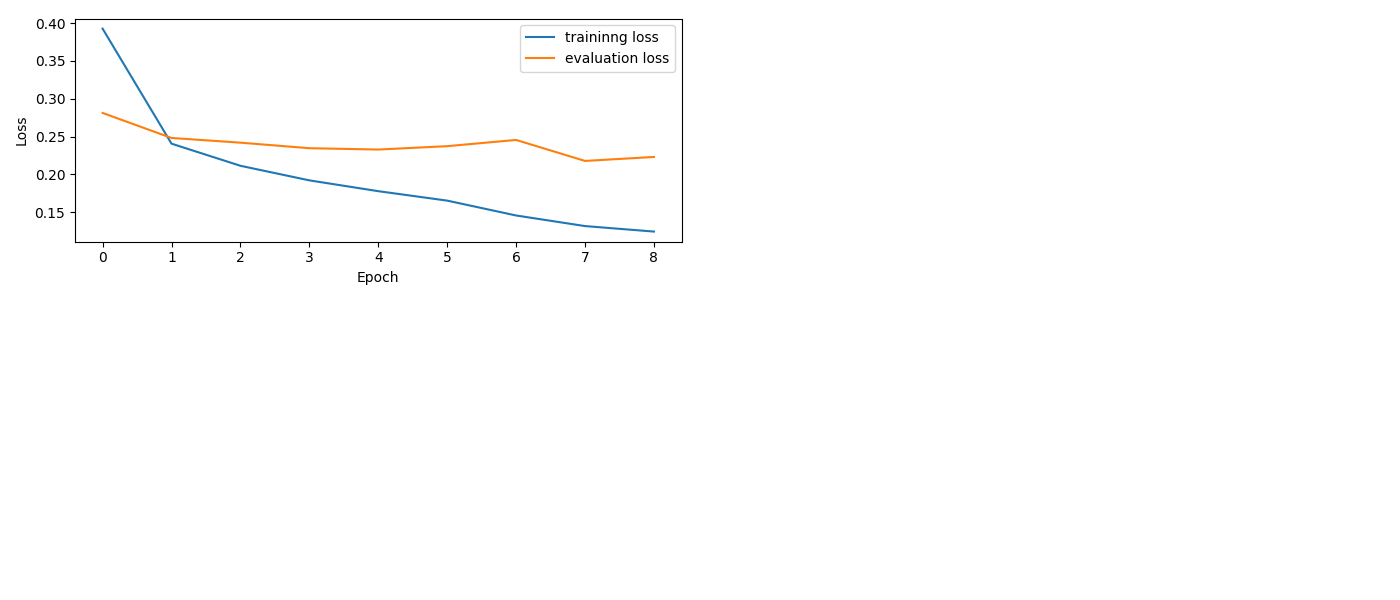

Start/Continue training from epoch 9
Finish training for 9 epochs


In [11]:
# run!!!!!!!!!!!!
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=9, plot=lambda exp: plot(exp, fig=fig, axes=axes))

# Testing

In [12]:
# Output some results
model = exp1.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(1215)
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    prediction = model([images])
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.2)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
    

[{'boxes': tensor([[ 82.5340, 405.6781, 164.2205, 505.8753],
        [455.4494, 445.0569, 686.6346, 758.8978],
        [463.8944, 336.7001, 679.3666, 693.2681],
        [582.4550, 336.5211, 688.8102, 630.8608],
        [590.8730, 326.7239, 674.6194, 498.1633],
        [516.8197, 322.8248, 675.3436, 583.1828],
        [409.6780, 636.6921, 478.2214, 729.9289],
        [456.8074, 472.5101, 618.5368, 682.5536]], device='cuda:0'), 'labels': tensor([19,  8, 14, 14, 14, 14,  8,  8], device='cuda:0'), 'scores': tensor([0.9952, 0.9853, 0.9086, 0.3634, 0.3537, 0.2334, 0.0634, 0.0555],
       device='cuda:0')}]
---------------------------------
{'boxes': tensor([[468.8000, 478.0781, 691.2000, 751.9520],
        [ 80.0000, 408.4084, 163.2000, 506.9069],
        [412.8000, 326.7267, 678.4000, 732.7327]], device='cuda:0'), 'labels': tensor([ 8, 19, 14], device='cuda:0', dtype=torch.int32)}
---------------------------------
{'boxes': tensor([[455.4494, 445.0569, 686.6346, 758.8978],
        [ 82.5340

<IPython.core.display.Javascript object>


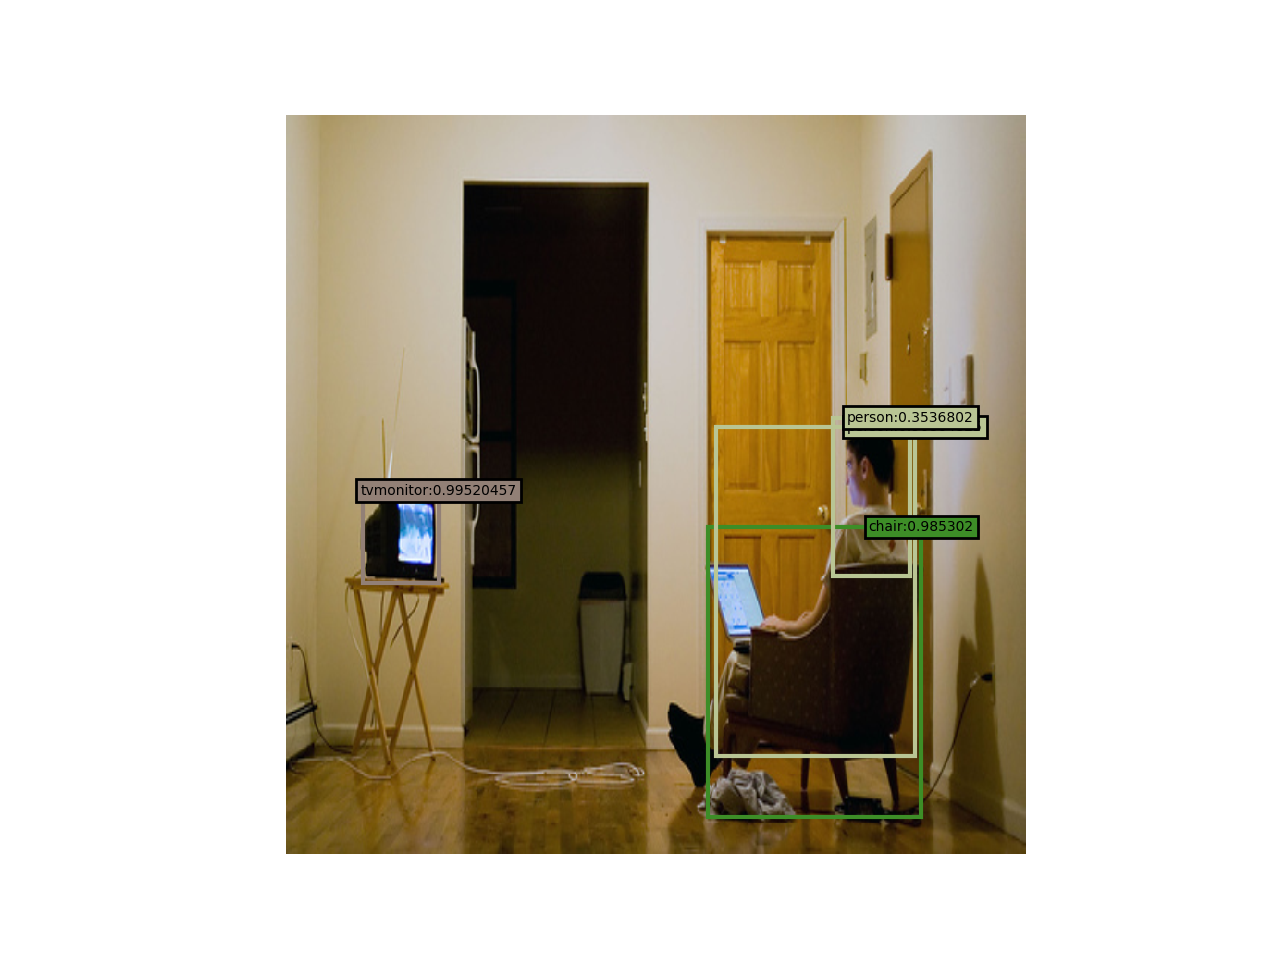

In [15]:
myimshow_score(images, res)

# Evaluation

In [14]:
import evaluation_voc
model = exp1.net
model.eval()
recall, precision, aps = evaluation_voc.run(model,val_set,device,thr = 0.5)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
---class aeroplane ap 0---
---class bicycle ap 0.8194075994299554---
---class bird ap 0.7956268011935239---
---class boat ap 0.6494860175547076---
---class bottle ap 0.658286149588392---
---class bus ap 0.8515088265260637---
---class car ap 0.8289890629538603---
---class cat ap 0.9201345387392836---
---class chair ap 0.5775837698342481---
---class cow ap 0.8021528601212848---
---class diningtable ap 0.6351181345492056---
---class dog ap 0.8270728024312672---
---class horse ap 0.843054867329424---
---class motorbike ap 0.8612131887981553---
---class person ap 0.8650857725117728---
---class pottedplant ap 0.5683088195812955---
---class sheep ap 0.8075317683271428---
---class sofa ap 0.686984360008667---
---class train ap 0.8497802341980747---
---class tvmonitor ap 0.7620357133920168---
---map 0.7304680643534172---
time cost 2718.60892868042 s


In [31]:
base_dir = os.getcwd()
file_name = os.path.join(base_dir, 'evaluation.txt')
my_open = open(file_name, 'a')
my_open.write('ResNet\n')
my_open.write(str(map1))
my_open.write('\n')
my_open.close()

In [17]:
aps

[0,
 0.8194075994299554,
 0.7956268011935239,
 0.6494860175547076,
 0.658286149588392,
 0.8515088265260637,
 0.8289890629538603,
 0.9201345387392836,
 0.5775837698342481,
 0.8021528601212848,
 0.6351181345492056,
 0.8270728024312672,
 0.843054867329424,
 0.8612131887981553,
 0.8650857725117728,
 0.5683088195812955,
 0.8075317683271428,
 0.686984360008667,
 0.8497802341980747,
 0.7620357133920168]